<a href="https://colab.research.google.com/github/l-kaif-l/DQN_induced_Diet_recommendation/blob/main/DQN_Diet_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch numpy


# Data


In [ ]:
import pandas as pd

# List of all the CSV files in the dataset
csv_files = [
    'FOOD-DATA-GROUP1.csv',
    'FOOD-DATA-GROUP2.csv',
    'FOOD-DATA-GROUP3.csv',
    'FOOD-DATA-GROUP4.csv',
    'FOOD-DATA-GROUP5.csv'
]

# Load and concatenate all food data CSVs
food_data_list = [pd.read_csv(file_path) for file_path in csv_files]
food_data = pd.concat(food_data_list, ignore_index=True)

# Select relevant columns (or all columns as needed)
food_data = food_data[['food', 'Caloric Value', 'Fat', 'Carbohydrates', 'Nutrition Density']]  # Adjust as needed

# Handle missing values if any (e.g., fill with mean)
# food_data.fillna(food_data.mean(), inplace=True)

# Now you can pass `food_data` into the training function


# Auto DQN

In [ ]:
class MonteCarloControlWithQTable(MonteCarloControlWithImprovements):  # Inherit the improved version
    def display_q_table(self):
        """Display the Q-value table"""
        print("Q-Value Table:")
        for state, action_values in self.Q.items():
            print(f"\nState (Preferences): {state}")
            for action_idx, q_value in enumerate(action_values):
                food_item = self.food_data.iloc[action_idx]['food']
                print(f"  Action (Recommend {food_item}): Q-Value = {q_value:.2f}")


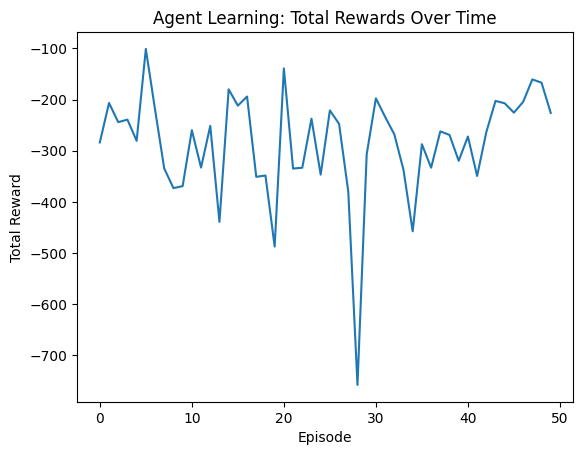

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the DQN model
class DQNUpdated(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNUpdated, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay memory for experience replay
class ReplayMemoryUpdated:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Food environment with updated step and reward functions
class FoodEnvUpdated:
    def __init__(self, food_data):
        self.food_data = food_data
        self.num_actions = len(food_data)
        self.reset()

    def reset(self):
        self.user_state = np.random.rand(3) * 100  # User's caloric, fat, and carbohydrate goals/preferences
        return self.user_state

    def step(self, action):
        food_item = self.food_data.iloc[action]
        reward = self.get_reward(food_item)
        next_state = self.user_state + np.random.normal(0, 5, size=self.user_state.shape)
        done = False
        return next_state, reward, done

    def get_reward(self, food_item):
        user_caloric_pref, user_fat_pref, user_carb_pref = self.user_state
        food_caloric_value = food_item['Caloric Value']
        food_fat = food_item['Fat']
        food_carbs = food_item['Carbohydrates']

        caloric_reward = -abs(user_caloric_pref - food_caloric_value) / 100
        fat_reward = -abs(user_fat_pref - food_fat) / 10
        carb_reward = -abs(user_carb_pref - food_carbs) / 10

        total_reward = caloric_reward + fat_reward + carb_reward
        return total_reward

# Adjusted training function with tracking and plotting
def train_dqn_with_tracking(food_data):
    state_size = 3  # User preferences: caloric, fat, carbs
    action_size = len(food_data)

    policy_net = DQNUpdated(state_size, action_size)
    target_net = DQNUpdated(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = ReplayMemoryUpdated(10000)
    food_env = FoodEnvUpdated(food_data)

    epsilon = 0.5
    epsilon_min = 0.01
    epsilon_decay = 0.995
    gamma = 0.99
    target_update = 10
    num_episodes = 50  # Adjusted for faster training
    steps_per_episode = 25  # Adjusted for faster training
    batch_size = 32  # Reduced batch size for faster training

    # Tracking rewards
    total_rewards = []

    for episode in range(num_episodes):
        state = food_env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0  # Initialize reward for this episode

        for t in range(steps_per_episode):
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.randrange(action_size)
            else:
                with torch.no_grad():
                    action = policy_net(state).argmax().item()

            next_state, reward, done = food_env.step(action)
            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            memory.push((state, action, reward, next_state, done))
            state = next_state

            total_reward += reward.item()  # Accumulate rewards

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, _ = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_next_state = torch.cat(batch_next_state)
                batch_reward = torch.cat(batch_reward)

                current_q_values = policy_net(batch_state).gather(1, torch.tensor(batch_action).unsqueeze(1))
                next_q_values = target_net(batch_next_state).max(1)[0].detach()
                expected_q_values = batch_reward + (gamma * next_q_values)

                loss = nn.functional.mse_loss(current_q_values.squeeze(), expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        total_rewards.append(total_reward)  # Store total reward for this episode

        # Decay epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Plotting the total rewards to show learning progress
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Agent Learning: Total Rewards Over Time')
    plt.show()

    return policy_net

# Example usage with food_data
trained_model = train_dqn_with_tracking(food_data)


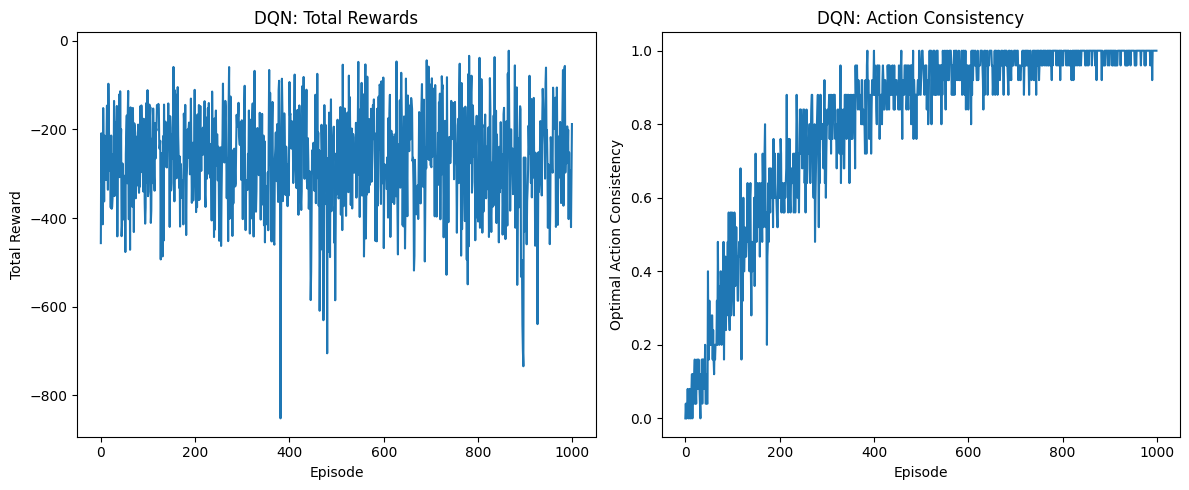

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

def train_dqn_with_metrics(food_data):
    state_size = 3
    action_size = len(food_data)

    policy_net = DQNUpdated(state_size, action_size)
    target_net = DQNUpdated(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = ReplayMemoryUpdated(10000)
    food_env = FoodEnvUpdated(food_data)

    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    gamma = 0.99
    target_update = 10
    num_episodes = 1000
    steps_per_episode = 25
    batch_size = 32

    total_rewards = []
    optimal_actions = []

    for episode in range(num_episodes):
        state = food_env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0
        optimal_action_count = 0

        for t in range(steps_per_episode):
            if random.uniform(0, 1) < epsilon:
                action = random.randrange(action_size)
            else:
                with torch.no_grad():
                    action = policy_net(state).argmax().item()

            next_state, reward, done = food_env.step(action)
            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            memory.push((state, action, reward, next_state, done))
            state = next_state

            total_reward += reward.item()
            optimal_action_count += (action == policy_net(state).argmax().item())  # Track optimal action

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, _ = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_next_state = torch.cat(batch_next_state)
                batch_reward = torch.cat(batch_reward)

                current_q_values = policy_net(batch_state).gather(1, torch.tensor(batch_action).unsqueeze(1))
                next_q_values = target_net(batch_next_state).max(1)[0].detach()
                expected_q_values = batch_reward + (gamma * next_q_values)

                loss = nn.functional.mse_loss(current_q_values.squeeze(), expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        total_rewards.append(total_reward)
        optimal_actions.append(optimal_action_count / steps_per_episode)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Plotting metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN: Total Rewards')

    plt.subplot(1, 2, 2)
    plt.plot(optimal_actions)
    plt.xlabel('Episode')
    plt.ylabel('Optimal Action Consistency')
    plt.title('DQN: Action Consistency')

    plt.tight_layout()
    plt.show()

# Run DQN with metrics
trained_model_with_metrics = train_dqn_with_metrics(food_data)


# Prints Q Values and State Prefrences


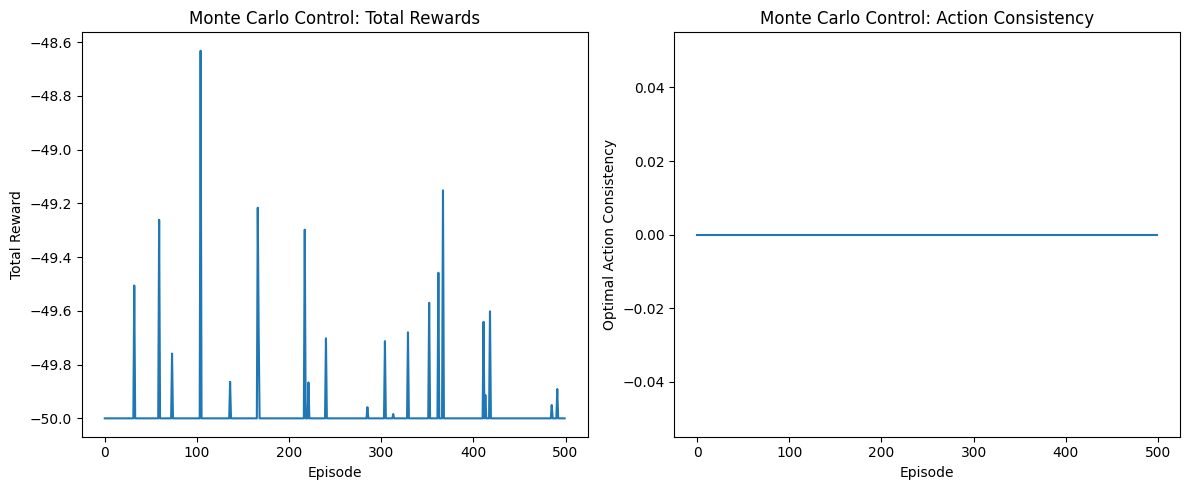

Streaming output truncated to the last 5000 lines.
  Action (Recommend milkfish raw): Q-Value = 0.10
  Action (Recommend eel raw): Q-Value = 0.10
  Action (Recommend catfish raw): Q-Value = 0.10
  Action (Recommend fish sticks): Q-Value = 0.10
  Action (Recommend coho salmon raw): Q-Value = 0.10
  Action (Recommend monkfish cooked): Q-Value = 0.10
  Action (Recommend yellowtail cooked): Q-Value = 0.10
  Action (Recommend yellowfin tuna cooked): Q-Value = 0.10
  Action (Recommend ling cooked): Q-Value = 0.10
  Action (Recommend eel cooked): Q-Value = 0.10
  Action (Recommend sablefish raw): Q-Value = 0.10
  Action (Recommend salmon nuggets): Q-Value = 0.10
  Action (Recommend yellowtail raw): Q-Value = 0.10
  Action (Recommend butterfish cooked): Q-Value = 0.10
  Action (Recommend caviar): Q-Value = 0.10
  Action (Recommend pollock raw): Q-Value = 0.10
  Action (Recommend catfish cooked): Q-Value = 0.10
  Action (Recommend whiting raw): Q-Value = 0.10
  Action (Recommend pink salmon raw

KeyboardInterrupt: 

In [ ]:
# # Assuming monte_carlo_agent_improved is your trained agent
# monte_carlo_agent_improved = MonteCarloControlWithQTable(food_data)

# # Train the agent
# monte_carlo_agent_improved.train(num_episodes=500)

# # Display the Q-value table
# monte_carlo_agent_improved.display_q_table()

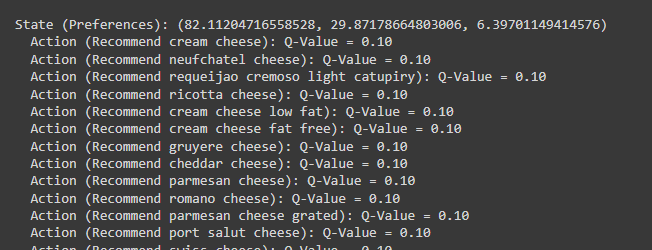

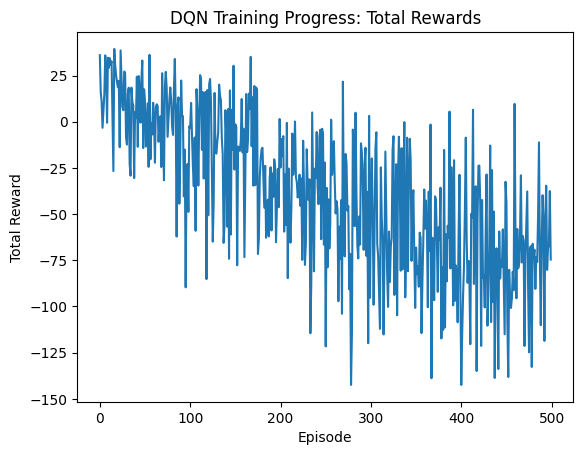

Recommended Dishes to Meet Nutritional Goals: ['Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almonds', 'Almond

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay memory for experience replay
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define the diet environment
class DietEnv:
    def __init__(self, food_data, nutritional_goals):
        self.food_data = food_data
        self.num_actions = len(food_data)
        self.nutritional_goals = nutritional_goals  # Target daily goals (calories, proteins, etc.)
        self.previous_recommendation = None  # To keep track of the last recommended food
        self.reset()

    def reset(self):
        # Start with zero intake for each nutritional element
        self.current_intake = {
            'Calories': 0,
            'Proteins': 0,
            'Fats': 0,
            'Carbs': 0,
            'Fiber': 0,
            'Vitamins': 0,
            'Minerals': 0
        }
        self.previous_recommendation = None  # Reset previous recommendation
        return np.array(list(self.current_intake.values()))  # Return current intake as state

    def step(self, action):
        food_item = self.food_data.iloc[action]
        reward = self.get_reward(food_item)

        # Update current intake based on the food item
        self.current_intake['Calories'] += food_item['Calories']
        self.current_intake['Proteins'] += food_item['Proteins']
        self.current_intake['Fats'] += food_item['Fats']
        self.current_intake['Carbs'] += food_item['Carbs']
        self.current_intake['Fiber'] += food_item['Fiber']
        self.current_intake['Vitamins'] += food_item['Vitamins']
        self.current_intake['Minerals'] += food_item['Minerals']

        next_state = np.array(list(self.current_intake.values()))  # Return updated intake as new state
        done = self.is_goal_met()  # Check if daily goals are met
        return next_state, reward, done

    def get_reward(self, food_item):
        # Adjusted reward system
        reward = 0

        # Loop over all nutrient goals and compute reward based on current intake
        for key in self.current_intake.keys():
            intake = self.current_intake[key] + food_item[key]
            goal = self.nutritional_goals[key]

            # If the intake is less than the goal, positive reward for getting closer
            if intake <= goal:
                reward += (goal - intake) / goal  # Encourage reaching the goal
            else:
                reward -= 2 * (intake - goal) / goal  # Penalize overshooting more heavily

        # Apply diversity penalty: discourage choosing the same food repeatedly
        if food_item['Food'] == self.previous_recommendation:
            reward -= 1  # Small penalty for recommending the same food

        # Update the last recommended food
        self.previous_recommendation = food_item['Food']

        return reward

    def is_goal_met(self):
        # Check if all daily nutritional goals are met
        return all(self.current_intake[key] >= self.nutritional_goals[key] for key in self.nutritional_goals.keys())

# Training the DQN model
def train_dqn(food_data, nutritional_goals):
    state_size = 7  # Number of nutritional elements (calories, proteins, fats, etc.)
    action_size = len(food_data)

    policy_net = DQN(state_size, action_size)
    target_net = DQN(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = ReplayMemory(10000)
    env = DietEnv(food_data, nutritional_goals)

    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.998  # Slower decay to promote exploration
    gamma = 0.99
    target_update = 10
    num_episodes = 500
    steps_per_episode = 10
    batch_size = 32

    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        for t in range(steps_per_episode):
            if random.uniform(0, 1) < epsilon:
                action = random.randrange(action_size)  # Explore
            else:
                with torch.no_grad():
                    action = policy_net(state).argmax().item()  # Exploit

            next_state, reward, done = env.step(action)
            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            memory.push((state, action, reward, next_state, done))
            state = next_state

            total_reward += reward.item()

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, _ = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_next_state = torch.cat(batch_next_state)
                batch_reward = torch.cat(batch_reward)

                current_q_values = policy_net(batch_state).gather(1, torch.tensor(batch_action).unsqueeze(1))
                next_q_values = target_net(batch_next_state).max(1)[0].detach()
                expected_q_values = batch_reward + (gamma * next_q_values)

                loss = nn.functional.mse_loss(current_q_values.squeeze(), expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        total_rewards.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Plot total rewards
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Progress: Total Rewards')
    plt.show()

    return policy_net

# Suggest dishes based on trained model
def suggest_dishes(policy_net, food_data, nutritional_goals):
    env = DietEnv(food_data, nutritional_goals)
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)

    recommendations = []

    while True:
        with torch.no_grad():
            action = policy_net(state).argmax().item()  # Choose the best action (dish)

        food_item = food_data.iloc[action]['Food']
        recommendations.append(food_item)

        next_state, _, done = env.step(action)
        state = torch.tensor([next_state], dtype=torch.float32)

        if done:  # Stop recommending once nutritional goals are met
            break

    return recommendations

# Example food data (as per your earlier data)
data = {
    'Food': ['Apple', 'Banana', 'Chicken Breast', 'Almonds', 'Broccoli', 'Eggs', 'Salmon', 'Rice'],
    'Calories': [95, 105, 165, 575, 55, 78, 206, 205],
    'Proteins': [0.5, 1.3, 31, 21, 4, 6, 22, 4.2],
    'Fats': [0.3, 0.4, 3.6, 49, 0.6, 5, 12, 0.4],
    'Carbs': [25, 27, 0, 20, 11, 1, 0, 44],
    'Fiber': [4.4, 3.1, 0, 12.5, 2.4, 0, 0, 0.6],
    'Vitamins': [10, 15, 2, 1, 30, 10, 5, 1],
    'Minerals': [5, 10, 20, 40, 25, 10, 15, 3]
}

# Convert to DataFrame
food_data = pd.DataFrame(data)

# Nutritional goals (for the day)
nutritional_goals = {
    'Calories': 2000,
    'Proteins': 50,
    'Fats': 70,
    'Carbs': 250,
    'Fiber': 30,
    'Vitamins': 100,
    'Minerals': 100
}

# Train the model
trained_policy_net = train_dqn(food_data, nutritional_goals)

# Get diet recommendations after training
recommended_dishes = suggest_dishes(trained_policy_net, food_data, nutritional_goals)
print("Recommended Dishes to Meet Nutritional Goals:", recommended_dishes)


# Manual DQN


In [ ]:
# # Updated environment with manual input
# class FoodEnvManual:
#     def __init__(self, food_data):
#         self.food_data = food_data
#         self.num_actions = len(food_data)
#         self.reset()

#     def reset(self):
#         self.user_state = np.random.rand(3) * 100  # User's caloric, fat, and carbohydrate goals/preferences
#         return self.user_state

#     def step(self, action):
#         # Fetch the recommended food item based on the action (index)
#         food_item = self.food_data.iloc[action]

#         # Display the chosen food and its nutritional values
#         print(f"Recommended Food: {food_item['food']}")
#         print(f"Caloric Value: {food_item['Caloric Value']}, Fat: {food_item['Fat']}, Carbohydrates: {food_item['Carbohydrates']}")

#         # Get manual reward input (you provide feedback)
#         reward = float(input("Enter reward (e.g., 1 for good, -1 for bad): "))

#         # Simulate user state update
#         next_state = self.user_state + np.random.normal(0, 5, size=self.user_state.shape)
#         done = False
#         return next_state, reward, done

# # Manual training function
# def train_dqn_manual(food_data):
#     state_size = 3  # User preferences: caloric, fat, carbs
#     action_size = len(food_data)

#     policy_net = DQNUpdated(state_size, action_size)
#     target_net = DQNUpdated(state_size, action_size)
#     target_net.load_state_dict(policy_net.state_dict())
#     target_net.eval()

#     optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
#     memory = ReplayMemoryUpdated(10000)
#     food_env = FoodEnvManual(food_data)  # Manual environment

#     epsilon = 1.0
#     epsilon_min = 0.01
#     epsilon_decay = 0.995
#     gamma = 0.99
#     target_update = 10
#     num_episodes = 5  # Reduced for manual input
#     steps_per_episode = 5  # Fewer steps for manual input
#     batch_size = 32  # Reduced batch size for faster training

#     # Tracking rewards
#     total_rewards = []

#     for episode in range(num_episodes):
#         state = food_env.reset()
#         state = torch.tensor([state], dtype=torch.float32)
#         total_reward = 0  # Initialize reward for this episode

#         for t in range(steps_per_episode):
#             # Instead of automatic action selection, ask for manual input
#             print("\nChoose an action by entering the index of the food item:")
#             for i, food in enumerate(food_data['food']):
#                 print(f"{i}: {food}")
#             action = int(input("Enter the action (index of food item): "))

#             next_state, reward, done = food_env.step(action)
#             next_state = torch.tensor([next_state], dtype=torch.float32)
#             reward = torch.tensor([reward], dtype=torch.float32)

#             memory.push((state, action, reward, next_state, done))
#             state = next_state

#             total_reward += reward.item()  # Accumulate rewards

#             if len(memory) > batch_size:
#                 transitions = memory.sample(batch_size)
#                 batch_state, batch_action, batch_reward, batch_next_state, _ = zip(*transitions)

#                 batch_state = torch.cat(batch_state)
#                 batch_next_state = torch.cat(batch_next_state)
#                 batch_reward = torch.cat(batch_reward)

#                 current_q_values = policy_net(batch_state).gather(1, torch.tensor(batch_action).unsqueeze(1))
#                 next_q_values = target_net(batch_next_state).max(1)[0].detach()
#                 expected_q_values = batch_reward + (gamma * next_q_values)

#                 loss = nn.functional.mse_loss(current_q_values.squeeze(), expected_q_values)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if episode % target_update == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         total_rewards.append(total_reward)  # Store total reward for this episode

#         # Decay epsilon
#         if epsilon > epsilon_min:
#             epsilon *= epsilon_decay

#     # Plotting the total rewards to show learning progress
#     plt.plot(total_rewards)
#     plt.xlabel('Episode')
#     plt.ylabel('Total Reward')
#     plt.title('Agent Learning: Total Rewards Over Time')
#     plt.show()

#     return policy_net

# # Run the manual training
# trained_model = train_dqn_manual(food_data)


# Auto Monte Carlo

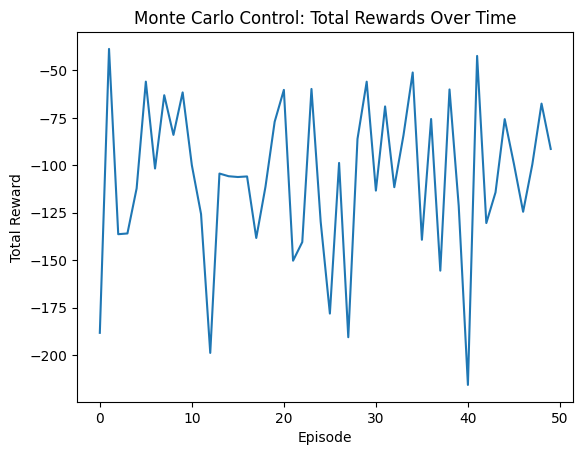

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Monte Carlo Control with epsilon-greedy policy
class MonteCarloControl:
    def __init__(self, food_data, gamma=0.9, epsilon=0.1):
        self.food_data = food_data
        self.num_actions = len(food_data)
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-values and returns for each state-action pair
        self.Q = {}  # Q[state][action] = value
        self.returns = {}  # To store returns for each state-action pair
        self.policy = {}  # Policy[state] = action

    def get_action(self, state):
        """Epsilon-greedy action selection"""
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.num_actions)  # Explore
        else:
            # Exploit - choose action with highest Q-value
            if state in self.Q:
                return np.argmax(self.Q[state])
            else:
                return random.randrange(self.num_actions)  # Random if uninitialized

    def generate_episode(self):
        """Generates an episode (state, action, reward) tuples"""
        episode = []
        state = np.random.rand(3) * 100  # Random initial user state (preferences)
        for _ in range(10):  # Limit episode length to 10 steps
            action = self.get_action(tuple(state))
            food_item = self.food_data.iloc[action]

            # Get the reward based on the food item
            reward = self.get_reward(food_item, state)

            # Store the state, action, reward tuple
            episode.append((tuple(state), action, reward))

            # Simulate next user state (small change for simplicity)
            state = state + np.random.normal(0, 5, size=state.shape)

        return episode

    def get_reward(self, food_item, state):
        """Calculate the reward based on how well food matches user preferences"""
        user_caloric_pref, user_fat_pref, user_carb_pref = state
        food_caloric_value = food_item['Caloric Value']
        food_fat = food_item['Fat']
        food_carbs = food_item['Carbohydrates']

        caloric_reward = -abs(user_caloric_pref - food_caloric_value) / 100
        fat_reward = -abs(user_fat_pref - food_fat) / 10
        carb_reward = -abs(user_carb_pref - food_carbs) / 10

        total_reward = caloric_reward + fat_reward + carb_reward
        return total_reward

    def update_q_values(self, episode):
        """Update Q-values based on the episode (First-Visit MC)"""
        G = 0  # Return
        visited = set()  # To track first-visit
        for step in reversed(episode):
            state, action, reward = step
            G = self.gamma * G + reward  # Calculate return

            if (state, action) not in visited:
                visited.add((state, action))  # First visit check

                if state not in self.returns:
                    self.returns[state] = {}
                if action not in self.returns[state]:
                    self.returns[state][action] = []

                # Append the return for this state-action pair
                self.returns[state][action].append(G)

                # Update Q-value: average of returns
                self.Q.setdefault(state, np.zeros(self.num_actions))
                self.Q[state][action] = np.mean(self.returns[state][action])

    def train(self, num_episodes=1000):
        total_rewards = []

        for episode in range(num_episodes):
            # Generate an episode
            episode_data = self.generate_episode()

            # Update Q-values based on this episode
            self.update_q_values(episode_data)

            # Track total reward for each episode (sum of rewards)
            total_episode_reward = sum([reward for _, _, reward in episode_data])
            total_rewards.append(total_episode_reward)

        # Plot the rewards to visualize agent learning
        plt.plot(total_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Monte Carlo Control: Total Rewards Over Time')
        plt.show()

        return self.Q

# Example usage with food_data (already preprocessed)
monte_carlo_agent = MonteCarloControl(food_data)
trained_q_values = monte_carlo_agent.train(num_episodes=50)  # Train for 500 episodes


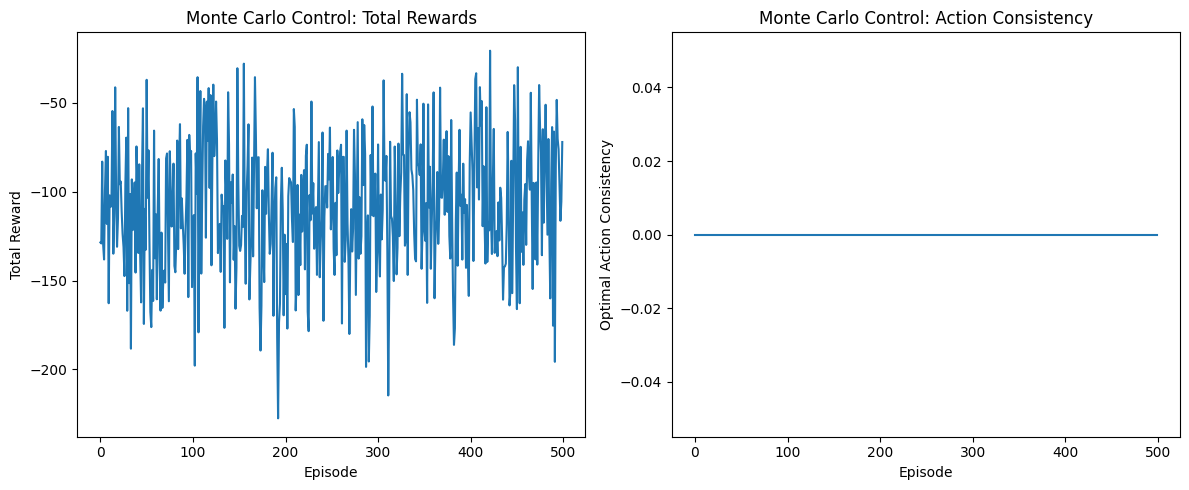

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class MonteCarloControlWithMetrics:
    def __init__(self, food_data, gamma=0.9, epsilon=0.1):
        self.food_data = food_data
        self.num_actions = len(food_data)
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-values and returns for each state-action pair
        self.Q = {}
        self.returns = {}

        # Metric tracking variables
        self.total_rewards = []
        self.optimal_actions = []

    def get_action(self, state):
        """Epsilon-greedy action selection"""
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.num_actions)  # Explore
        else:
            if state in self.Q:
                return np.argmax(self.Q[state])
            else:
                return random.randrange(self.num_actions)  # Random if uninitialized

    def generate_episode(self):
        """Generates an episode (state, action, reward) tuples"""
        episode = []
        state = np.random.rand(3) * 100  # Random initial user state (preferences)
        for _ in range(10):  # Limit episode length to 10 steps
            action = self.get_action(tuple(state))
            food_item = self.food_data.iloc[action]

            # Get the reward based on the food item
            reward = self.get_reward(food_item, state)

            # Store the state, action, reward tuple
            episode.append((tuple(state), action, reward))

            state = state + np.random.normal(0, 5, size=state.shape)

        return episode

    def get_reward(self, food_item, state):
        """Calculate the reward based on how well food matches user preferences"""
        user_caloric_pref, user_fat_pref, user_carb_pref = state
        food_caloric_value = food_item['Caloric Value']
        food_fat = food_item['Fat']
        food_carbs = food_item['Carbohydrates']

        caloric_reward = -abs(user_caloric_pref - food_caloric_value) / 100
        fat_reward = -abs(user_fat_pref - food_fat) / 10
        carb_reward = -abs(user_carb_pref - food_carbs) / 10

        total_reward = caloric_reward + fat_reward + carb_reward
        return total_reward

    def update_q_values(self, episode):
        G = 0  # Return
        visited = set()
        for step in reversed(episode):
            state, action, reward = step
            G = self.gamma * G + reward  # Calculate return

            if (state, action) not in visited:
                visited.add((state, action))

                if state not in self.returns:
                    self.returns[state] = {}
                if action not in self.returns[state]:
                    self.returns[state][action] = []

                self.returns[state][action].append(G)

                self.Q.setdefault(state, np.zeros(self.num_actions))
                self.Q[state][action] = np.mean(self.returns[state][action])

    def train(self, num_episodes=1000):
        for episode in range(num_episodes):
            episode_data = self.generate_episode()
            self.update_q_values(episode_data)

            total_episode_reward = sum([reward for _, _, reward in episode_data])
            self.total_rewards.append(total_episode_reward)

            # Track optimal action percentage
            optimal_action = 0
            for state, action, reward in episode_data:
                if state in self.Q:
                    optimal_action += (action == np.argmax(self.Q[state]))
            self.optimal_actions.append(optimal_action / len(episode_data))  # Track action consistency

        # Plot metrics
        self.plot_metrics()

    def plot_metrics(self):
        # Plot Total Rewards
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.total_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Monte Carlo Control: Total Rewards')

        # Plot Action Consistency
        plt.subplot(1, 2, 2)
        plt.plot(self.optimal_actions)
        plt.xlabel('Episode')
        plt.ylabel('Optimal Action Consistency')
        plt.title('Monte Carlo Control: Action Consistency')

        plt.tight_layout()
        plt.show()

# Usage for Monte Carlo Control
monte_carlo_agent_metrics = MonteCarloControlWithMetrics(food_data)
monte_carlo_agent_metrics.train(num_episodes=500)
